## **Fraud Detection Predictive Model2: TabNet**

* Input file: prepared_data2.csv (Loaded from feature engineering notebook)
* Output file: best_tabnet.zip (A trained model saved for performing model stacking)

** Running through the code requires 10+hrs and huge amount of computing units on colab pro. We're running out of computing units, so the results shown are based on our first version of feature engineering "prepared_data.csv" instead of "prepared_data2.csv"

### **Importing Libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import shap

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
import optuna

## **Load prepared dataset**

In [4]:
df = pd.read_csv('prepared_data2.csv')

In [5]:
df.head()

,amount,Target,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,use_chip_Chip Transaction,...,hour_Night,time_day_weekday_Afternoon,time_day_weekday_Evening,time_day_weekday_Morning,time_day_weekday_Night,time_day_weekend_Afternoon,time_day_weekend_Evening,time_day_weekend_Morning,time_day_weekend_Night,suspicious_indiv_activity
0,3.312730,0,56,65,9.522886,10.235019,11.592790,782,5,0,...,1,0,0,0,1,0,0,0,0,0
1,3.297317,0,52,71,10.438196,11.150592,10.762022,684,4,0,...,1,0,0,0,1,0,0,0,0,0
2,2.413232,0,47,69,10.152494,10.864924,11.815398,679,1,0,...,1,0,0,0,1,0,0,0,0,0
3,3.159975,0,59,70,9.767439,10.479848,11.436088,720,4,0,...,1,0,0,0,1,0,0,0,0,0
4,5.602930,0,70,59,10.194776,10.643113,10.299374,633,5,0,...,1,0,0,0,1,0,0,0,0,0


In [7]:
# Define independent (X) and dependent (y) variables
X = df.drop(columns=['Target'])  # Drop the target column
y = df['Target']  # Target variable

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Verify fraud ratio in original data and in train and test
print("Fraud ratio in original data: ", round(df['Target'].mean(), 3))
print("Fraud ratio in train data: ", round(y_train.mean(), 3))
print("Fraud ratio in test data: ", round(y_test.mean(), 3))

Fraud ratio in original data:  0.001
Fraud ratio in train data:  0.001
Fraud ratio in test data:  0.001


## **Handle imbalance dataset**

Fraud is extremely rare in the real world, accounting for only 0.15% of all instances in our dataset. To prevent the model from simply predicting the majority class (non-fraud), we apply the following strategies to address the class imbalance:

1. Oversampling: Increase the proportion of fraud cases to 20% of the training set.
2. Undersampling: Reduce the number of non-fraud cases to achieve a 1:3 fraud-to-non-fraud ratio.
3. Class Weights: Assign higher weights to fraud cases to penalize misclassification more heavily, ensuring the model learns to detect fraud effectively.

In [8]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)


In [9]:
# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)
class_weight_dict = dict(zip(np.unique(y_resampled), class_weights))

print("Class weights: ", class_weight_dict)

Class weights:  {0: 0.6500000105317857, 1: 2.166666549646834}


## **Modelling**

In [11]:
# Define custom PR-AUC metric as a class
class PRAUCMetric(Metric):
    def __init__(self):
        self._name = "pr_auc"
        self._maximize = True  # Higher is better

    def __call__(self, y_true, y_pred):
        # Ensure y_pred is probability of class 1
        y_pred_proba = y_pred[:, 1] if y_pred.ndim > 1 else y_pred
        return average_precision_score(y_true, y_pred_proba)

# Initialize and train TabNet model with class weights
tabnet_model = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=5,
    gamma=1.2,
    lambda_sparse=0.001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.001),
    mask_type='sparsemax',
    verbose=1
)

tabnet_model.fit(
    X_resampled.values, y_resampled.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_metric=[PRAUCMetric],
    max_epochs=20,
    patience=5,
    batch_size=1024,
    virtual_batch_size=128,
    weights=class_weight_dict,
    compute_importance=False
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.14452 | val_0_pr_auc: 0.08002 |  0:07:55s
epoch 1  | loss: 0.06201 | val_0_pr_auc: 0.17943 |  0:15:45s
epoch 2  | loss: 0.04886 | val_0_pr_auc: 0.27828 |  0:23:31s
epoch 3  | loss: 0.04204 | val_0_pr_auc: 0.37078 |  0:31:17s
epoch 4  | loss: 0.03677 | val_0_pr_auc: 0.37429 |  0:39:02s
epoch 5  | loss: 0.03382 | val_0_pr_auc: 0.3885  |  0:46:48s
epoch 6  | loss: 0.03169 | val_0_pr_auc: 0.39113 |  0:54:34s
epoch 7  | loss: 0.02996 | val_0_pr_auc: 0.42381 |  1:02:19s
epoch 8  | loss: 0.02787 | val_0_pr_auc: 0.37931 |  1:10:04s
epoch 9  | loss: 0.02683 | val_0_pr_auc: 0.44188 |  1:17:49s
epoch 10 | loss: 0.02524 | val_0_pr_auc: 0.42087 |  1:25:36s
epoch 11 | loss: 0.02412 | val_0_pr_auc: 0.43505 |  1:33:25s
epoch 12 | loss: 0.02339 | val_0_pr_auc: 0.44851 |  1:41:10s
epoch 13 | loss: 0.02207 | val_0_pr_auc: 0.4511  |  1:48:54s
epoch 14 | loss: 0.02124 | val_0_pr_auc: 0.44712 |  1:56:38s
epoch 15 | loss: 0.02045 | val_0_pr_auc: 0.45902 |  2:04:23s
epoch 16 | loss: 0.02005

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at tabnet_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1780327
           1       0.13      0.61      0.22      2666

    accuracy                           0.99   1782993
   macro avg       0.57      0.80      0.61   1782993
weighted avg       1.00      0.99      1.00   1782993



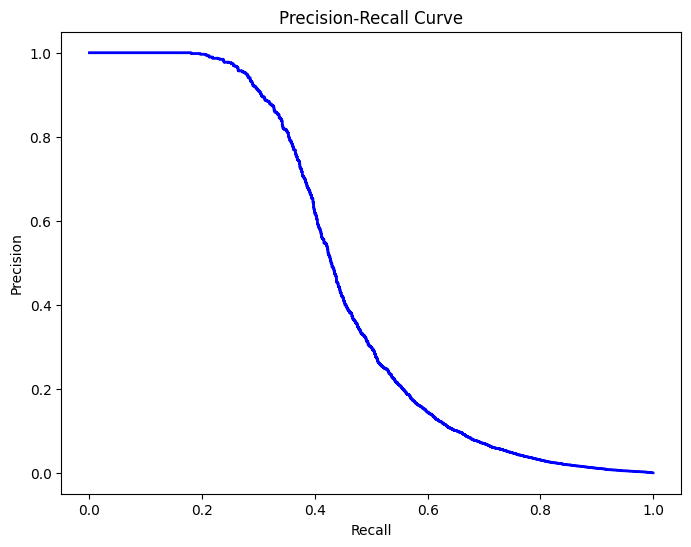

In [12]:
threshold = 0.5
y_pred_proba = tabnet_model.predict_proba(X_test.values)[:, 1]
y_pred_tabnet = (y_pred_proba > threshold).astype(int)

# Generate the classification report
print(classification_report(y_test.values, y_pred_tabnet))

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## **Tuning**

In [12]:
def objective(trial):
    # Suggest hyperparameters
    n_d = trial.suggest_int("n_d", 8, 32, step=8)
    n_a = trial.suggest_int("n_a", 8, 32, step=8)
    n_steps = trial.suggest_int("n_steps", 3, 7)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-5, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-3, 2e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [512, 1024, 2048])

    tabnet_model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="sparsemax",
        verbose=1
    )

    tabnet_model.fit(
        X_resampled.values, y_resampled.values,
        eval_set=[(X_test.values, y_test.values)],
        eval_metric=[PRAUCMetric],
        max_epochs=10,
        patience=3,
        batch_size=batch_size,
        virtual_batch_size=128,
        weights=class_weight_dict,
        compute_importance=False
    )

    # Evaluate PR-AUC
    y_pred_proba = tabnet_model.predict_proba(X_test.values)[:, 1]
    pr_auc = average_precision_score(y_test, y_pred_proba)

    return pr_auc

study = optuna.create_study(direction="maximize")  # Maximize PR-AUC
study.optimize(objective, n_trials=10)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2025-02-26 14:34:18,533] A new study created in memory with name: no-name-6b0e4bc4-e443-4160-b375-9bc9af728a83
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.07287 | val_0_pr_auc: 0.35185 |  0:04:30s
epoch 1  | loss: 0.04403 | val_0_pr_auc: 0.29063 |  0:09:04s
epoch 2  | loss: 0.03833 | val_0_pr_auc: 0.29907 |  0:13:36s
epoch 3  | loss: 0.0293  | val_0_pr_auc: 0.33769 |  0:18:06s

Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_pr_auc = 0.35185


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 14:53:06,802] Trial 0 finished with value: 0.3518494038677043 and parameters: {'n_d': 24, 'n_a': 32, 'n_steps': 4, 'gamma': 1.2647628681441918, 'lambda_sparse': 0.0007815524153941117, 'lr': 0.015938574462263207, 'batch_size': 2048}. Best is trial 0 with value: 0.3518494038677043.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0723  | val_0_pr_auc: 0.22096 |  0:04:26s
epoch 1  | loss: 0.04516 | val_0_pr_auc: 0.29884 |  0:08:50s
epoch 2  | loss: 0.03151 | val_0_pr_auc: 0.35357 |  0:13:10s
epoch 3  | loss: 0.02416 | val_0_pr_auc: 0.33321 |  0:17:29s
epoch 4  | loss: 0.0207  | val_0_pr_auc: 0.39406 |  0:21:47s
epoch 5  | loss: 0.01926 | val_0_pr_auc: 0.40439 |  0:26:04s
epoch 6  | loss: 0.01748 | val_0_pr_auc: 0.3778  |  0:30:22s
epoch 7  | loss: 0.01687 | val_0_pr_auc: 0.41922 |  0:34:39s
epoch 8  | loss: 0.01564 | val_0_pr_auc: 0.42032 |  0:38:55s
epoch 9  | loss: 0.01461 | val_0_pr_auc: 0.40228 |  0:43:12s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_pr_auc = 0.42032


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 15:36:56,406] Trial 1 finished with value: 0.42032278794439976 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.505765849322037, 'lambda_sparse': 0.0008735017455803443, 'lr': 0.018643868739369636, 'batch_size': 2048}. Best is trial 1 with value: 0.42032278794439976.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.07715 | val_0_pr_auc: 0.35977 |  0:05:30s
epoch 1  | loss: 0.03912 | val_0_pr_auc: 0.3593  |  0:11:06s
epoch 2  | loss: 0.02978 | val_0_pr_auc: 0.36697 |  0:16:38s
epoch 3  | loss: 0.02506 | val_0_pr_auc: 0.37236 |  0:22:10s
epoch 4  | loss: 0.02257 | val_0_pr_auc: 0.38754 |  0:27:45s
epoch 5  | loss: 0.02092 | val_0_pr_auc: 0.38892 |  0:33:20s
epoch 6  | loss: 0.01969 | val_0_pr_auc: 0.37143 |  0:38:56s
epoch 7  | loss: 0.01873 | val_0_pr_auc: 0.34398 |  0:44:31s
epoch 8  | loss: 0.01819 | val_0_pr_auc: 0.39176 |  0:50:03s
epoch 9  | loss: 0.01746 | val_0_pr_auc: 0.35947 |  0:55:38s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_pr_auc = 0.39176


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 16:33:21,722] Trial 2 finished with value: 0.3917609890429284 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 4, 'gamma': 1.0664089774588694, 'lambda_sparse': 0.00040690532211853627, 'lr': 0.006888253450527749, 'batch_size': 1024}. Best is trial 1 with value: 0.42032278794439976.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.10044 | val_0_pr_auc: 0.1142  |  0:05:49s
epoch 1  | loss: 0.05465 | val_0_pr_auc: 0.17202 |  0:11:36s
epoch 2  | loss: 0.04573 | val_0_pr_auc: 0.27515 |  0:17:23s
epoch 3  | loss: 0.03629 | val_0_pr_auc: 0.34682 |  0:23:09s
epoch 4  | loss: 0.02999 | val_0_pr_auc: 0.33808 |  0:28:58s
epoch 5  | loss: 0.02617 | val_0_pr_auc: 0.3422  |  0:34:48s
epoch 6  | loss: 0.02464 | val_0_pr_auc: 0.35763 |  0:40:36s
epoch 7  | loss: 0.02458 | val_0_pr_auc: 0.29506 |  0:46:26s
epoch 8  | loss: 0.02674 | val_0_pr_auc: 0.34168 |  0:52:16s
epoch 9  | loss: 0.02298 | val_0_pr_auc: 0.33168 |  0:58:04s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_pr_auc = 0.35763


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 17:32:13,924] Trial 3 finished with value: 0.3576332060341773 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 6, 'gamma': 1.7650308735832527, 'lambda_sparse': 0.0009097512615886741, 'lr': 0.014858558658573464, 'batch_size': 2048}. Best is trial 1 with value: 0.42032278794439976.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.15825 | val_0_pr_auc: 0.11844 |  0:11:10s
epoch 1  | loss: 0.05737 | val_0_pr_auc: 0.23568 |  0:22:40s
epoch 2  | loss: 0.04673 | val_0_pr_auc: 0.31035 |  0:33:32s
epoch 3  | loss: 0.04113 | val_0_pr_auc: 0.30768 |  0:44:24s
epoch 4  | loss: 0.03882 | val_0_pr_auc: 0.35018 |  0:55:24s
epoch 5  | loss: 0.03606 | val_0_pr_auc: 0.39013 |  1:06:18s
epoch 6  | loss: 0.03481 | val_0_pr_auc: 0.40969 |  1:17:12s
epoch 7  | loss: 0.03206 | val_0_pr_auc: 0.39473 |  1:28:07s
epoch 8  | loss: 0.02989 | val_0_pr_auc: 0.40988 |  1:38:57s
epoch 9  | loss: 0.02951 | val_0_pr_auc: 0.27109 |  1:50:35s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_pr_auc = 0.40988


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 19:24:14,808] Trial 4 finished with value: 0.4098751357824246 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 6, 'gamma': 1.314402160359712, 'lambda_sparse': 0.0009323422634726035, 'lr': 0.0013774950213434286, 'batch_size': 512}. Best is trial 1 with value: 0.42032278794439976.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.28598 | val_0_pr_auc: 0.04875 |  0:05:59s
epoch 1  | loss: 0.09287 | val_0_pr_auc: 0.15422 |  0:11:52s
epoch 2  | loss: 0.07436 | val_0_pr_auc: 0.16424 |  0:17:50s
epoch 3  | loss: 0.06353 | val_0_pr_auc: 0.23639 |  0:23:44s
epoch 4  | loss: 0.05684 | val_0_pr_auc: 0.28678 |  0:29:36s
epoch 5  | loss: 0.05347 | val_0_pr_auc: 0.30627 |  0:35:30s
epoch 6  | loss: 0.05155 | val_0_pr_auc: 0.3119  |  0:41:26s
epoch 7  | loss: 0.04799 | val_0_pr_auc: 0.31941 |  0:47:21s
epoch 8  | loss: 0.04504 | val_0_pr_auc: 0.33539 |  0:53:16s
epoch 9  | loss: 0.04563 | val_0_pr_auc: 0.323   |  0:59:10s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_pr_auc = 0.33539


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 20:24:13,898] Trial 5 finished with value: 0.33538828665802156 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 6, 'gamma': 1.7667390904367108, 'lambda_sparse': 0.0002396161419137252, 'lr': 0.00158763699227176, 'batch_size': 2048}. Best is trial 1 with value: 0.42032278794439976.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.10509 | val_0_pr_auc: 0.11183 |  0:04:38s
epoch 1  | loss: 0.05228 | val_0_pr_auc: 0.21923 |  0:09:21s
epoch 2  | loss: 0.04339 | val_0_pr_auc: 0.26279 |  0:14:04s
epoch 3  | loss: 0.03815 | val_0_pr_auc: 0.30158 |  0:18:42s
epoch 4  | loss: 0.03507 | val_0_pr_auc: 0.30702 |  0:23:18s
epoch 5  | loss: 0.03234 | val_0_pr_auc: 0.31139 |  0:27:54s
epoch 6  | loss: 0.03022 | val_0_pr_auc: 0.32071 |  0:32:29s
epoch 7  | loss: 0.02823 | val_0_pr_auc: 0.27315 |  0:37:05s
epoch 8  | loss: 0.02671 | val_0_pr_auc: 0.32771 |  0:41:40s
epoch 9  | loss: 0.02566 | val_0_pr_auc: 0.32128 |  0:46:16s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_pr_auc = 0.32771


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 21:11:09,353] Trial 6 finished with value: 0.3277086609925617 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 3, 'gamma': 1.1860256494553407, 'lambda_sparse': 0.00022985764014461928, 'lr': 0.0011253362442059207, 'batch_size': 1024}. Best is trial 1 with value: 0.42032278794439976.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.08148 | val_0_pr_auc: 0.23117 |  0:12:17s
epoch 1  | loss: 0.04086 | val_0_pr_auc: 0.32371 |  0:24:31s
epoch 2  | loss: 0.03803 | val_0_pr_auc: 0.15758 |  0:36:50s
epoch 3  | loss: 0.03438 | val_0_pr_auc: 0.30061 |  0:49:10s
epoch 4  | loss: 0.03217 | val_0_pr_auc: 0.29229 |  1:01:23s

Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_pr_auc = 0.32371


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 22:14:04,776] Trial 7 finished with value: 0.3237105994913646 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 7, 'gamma': 1.3310152064212584, 'lambda_sparse': 0.00011586002560399254, 'lr': 0.009148540446471433, 'batch_size': 512}. Best is trial 1 with value: 0.42032278794439976.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.14446 | val_0_pr_auc: 0.05244 |  0:05:07s
epoch 1  | loss: 0.06425 | val_0_pr_auc: 0.16725 |  0:10:20s
epoch 2  | loss: 0.05203 | val_0_pr_auc: 0.23858 |  0:15:28s
epoch 3  | loss: 0.04958 | val_0_pr_auc: 0.26552 |  0:20:33s
epoch 4  | loss: 0.04352 | val_0_pr_auc: 0.26334 |  0:25:39s
epoch 5  | loss: 0.04294 | val_0_pr_auc: 0.25593 |  0:30:45s
epoch 6  | loss: 0.03837 | val_0_pr_auc: 0.20086 |  0:35:50s

Early stopping occurred at epoch 6 with best_epoch = 3 and best_val_0_pr_auc = 0.26552


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 22:50:38,925] Trial 8 finished with value: 0.26552178635492946 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.8709741005215503, 'lambda_sparse': 1.4379368618518392e-05, 'lr': 0.0032799988453244854, 'batch_size': 2048}. Best is trial 1 with value: 0.42032278794439976.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.07136 | val_0_pr_auc: 0.29901 |  0:05:33s
epoch 1  | loss: 0.04045 | val_0_pr_auc: 0.39659 |  0:11:05s
epoch 2  | loss: 0.03513 | val_0_pr_auc: 0.23849 |  0:16:38s
epoch 3  | loss: 0.03041 | val_0_pr_auc: 0.29484 |  0:22:11s
epoch 4  | loss: 0.02665 | val_0_pr_auc: 0.27413 |  0:27:48s

Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_pr_auc = 0.39659


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-26 23:19:14,580] Trial 9 finished with value: 0.396589683775772 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'gamma': 1.6671737646576505, 'lambda_sparse': 0.0006299817443878067, 'lr': 0.011702240168522523, 'batch_size': 1024}. Best is trial 1 with value: 0.42032278794439976.


Best hyperparameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.505765849322037, 'lambda_sparse': 0.0008735017455803443, 'lr': 0.018643868739369636, 'batch_size': 2048}


## **Best TabNet Model Performance & Feature Importance**

In [15]:
best_params = study.best_params  # Get the best hyperparameters

# Train TabNet with the best hyperparameters
best_tabnet_model = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params["lr"]),
    mask_type="sparsemax",
    verbose=1
)

best_tabnet_model.fit(
    X_resampled.values, y_resampled.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_metric=[PRAUCMetric],
    max_epochs=20,
    patience=5,
    batch_size=best_params["batch_size"],
    virtual_batch_size=128,
    weights=class_weight_dict,
    compute_importance=True
)

# Save the best model
best_tabnet_model.save_model("best_tabnet")

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.0723  | val_0_pr_auc: 0.22096 |  0:04:31s
epoch 1  | loss: 0.04516 | val_0_pr_auc: 0.29884 |  0:09:02s
epoch 2  | loss: 0.03151 | val_0_pr_auc: 0.35357 |  0:13:33s
epoch 3  | loss: 0.02416 | val_0_pr_auc: 0.33321 |  0:18:05s
epoch 4  | loss: 0.0207  | val_0_pr_auc: 0.39406 |  0:22:55s
epoch 5  | loss: 0.01926 | val_0_pr_auc: 0.40439 |  0:27:45s
epoch 6  | loss: 0.01748 | val_0_pr_auc: 0.3778  |  0:32:35s
epoch 7  | loss: 0.01687 | val_0_pr_auc: 0.41922 |  0:37:26s
epoch 8  | loss: 0.01564 | val_0_pr_auc: 0.42032 |  0:42:17s
epoch 9  | loss: 0.01461 | val_0_pr_auc: 0.40228 |  0:47:07s
epoch 10 | loss: 0.01416 | val_0_pr_auc: 0.40811 |  0:51:57s
epoch 11 | loss: 0.01379 | val_0_pr_auc: 0.42115 |  0:56:49s
epoch 12 | loss: 0.01368 | val_0_pr_auc: 0.41537 |  1:01:38s
epoch 13 | loss: 0.01361 | val_0_pr_auc: 0.40553 |  1:06:29s
epoch 14 | loss: 0.01255 | val_0_pr_auc: 0.40935 |  1:11:19s
epoch 15 | loss: 0.01267 | val_0_pr_auc: 0.38014 |  1:16:09s
epoch 16 | loss: 0.01203

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.20      0.54      0.29      2666

    accuracy                           1.00   1782993
   macro avg       0.60      0.77      0.64   1782993
weighted avg       1.00      1.00      1.00   1782993



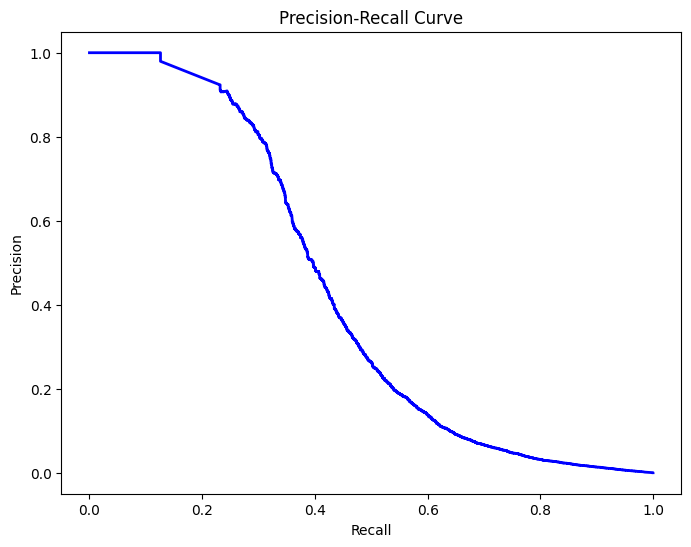

In [16]:
# Use the trained model for predictions
threshold = 0.5
y_pred_proba = best_tabnet_model.predict_proba(X_test.values)[:, 1]
y_pred = (y_pred_proba > threshold).astype(int)

# Generate the classification report
print(classification_report(y_test.values, y_pred))

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

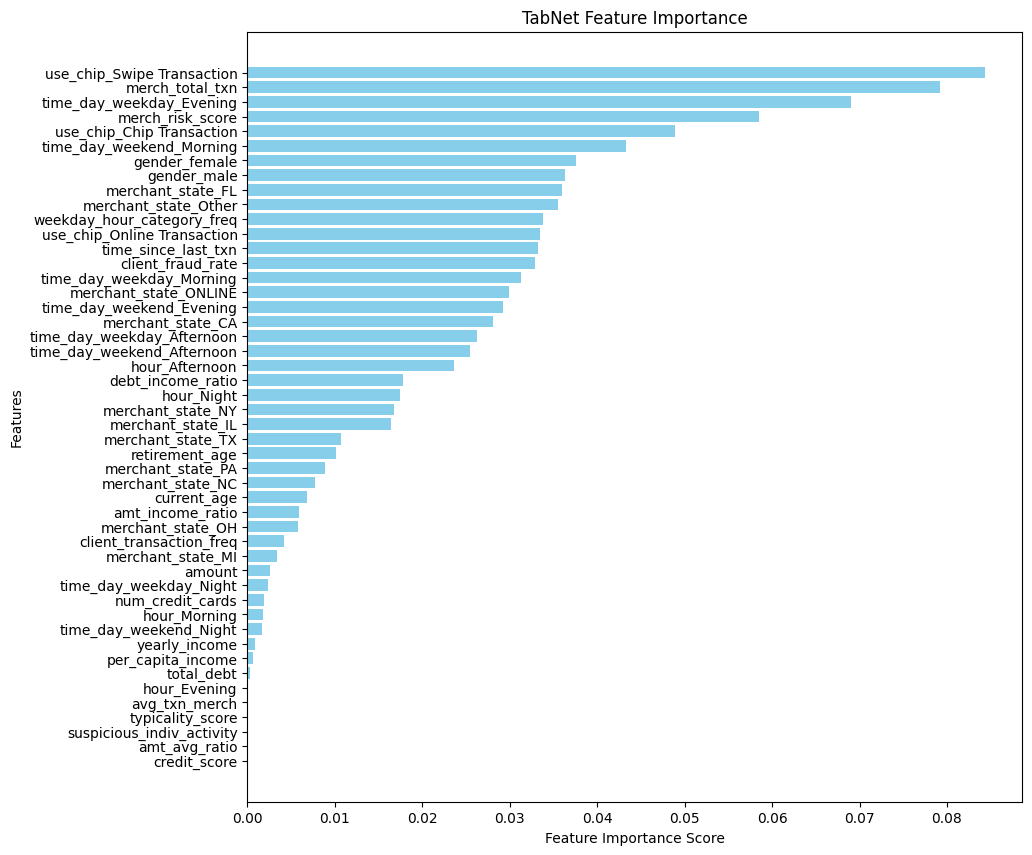

In [15]:
# Extract feature importance
feature_importance = best_tabnet_model.feature_importances_

# Get feature names (assuming X_train is a DataFrame)
feature_names = X_resampled.columns if hasattr(X_resampled, 'columns') else np.arange(len(feature_importance))

# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 10))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("TabNet Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [16]:
############## Subject to computation units limitation ##############

explainer = shap.Explainer(tabnet_model.predict, X_resampled.values)
shap_values = explainer(X_test.values)
shap.summary_plot(shap_values, X_test.values)

PermutationExplainer explainer:   0%|          | 536/1782993 [09:22<529:36:39,  1.07s/it]


KeyboardInterrupt: 